<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/VAE_markov_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We demonstrate now how to extend a VAE to include *inductive biases* which impose prior knowledge about system dynamics. We consider a trivial version of the pendulum problem presented in class, whereby we are only able to collect indirect measurements of the true dynamics. We consider a pendulum system, where the "hidden" data z satisfies the ODE governing the angular rotation of the pendulum.
$$\ddot{z} = - \lambda z$$
But we collect noisy data for the position of the pendulum bob.
$$ \vec{y}(t) = <\sin z(t), -\cos z(t)> + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$

This is a simplified example of trying to infer dynamics from video - here we want to find the $y\in\mathbb{R}^2 \rightarrow z \in\mathbb{R}$ map, while the full complexity problem of identifying dynamics from video frames would be a more expensive to solve $y\in\mathbb{R}^{N_{\text{pixels}}} \rightarrow z \in\mathbb{R}$ map.

There are two tasks to complete to build the architecture after generating the data set. First, we need to build up the VAE encoder and decoder that will take us back and forth between $y$ and $z$. Then we need to construct the ELBO loss function which will impose our assumed dynamics as a prior.

In [1]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


Here we are manufacturing our dataset. Note that you can control here the number of samples, as well as the magnitude of the noise we're introducing. This is useful for investigating how robust the method is to noise. For a real problem "noise" will not be Gaussian white noise added on top of the signal - it would be e.g. all of the background artifacts captured in the video.

In [2]:
Ndata = 2000 #how many trajectories to train on
Ntimes = 50  #how many timesteps of solution to save (important for time discretization)
dt = 1./Ntimes
z0 = np.random.uniform(-1,1,Ndata)
t = np.linspace(0,1,Ntimes)
theta_true = 1.0/(2.*np.pi)
zdata = np.expand_dims(z0,0)*np.cos((1./theta_true)*np.expand_dims(t,-1)) # this is "hidden" and not used during training

#generate observable coordinates
noise = 0.05 # play with this to add more/less noise
noiselessdata = np.stack([np.sin(zdata),-np.cos(zdata)],axis=2)
ydata = noiselessdata + np.random.normal(0,noise,[Ntimes,Ndata,2])
ydata = ydata.transpose([1,0,2]) # reshape data to match tensorflow model requirements

Next we build up the tensorflow model for the autoencoder, implementing two networks for the encoder and decoder, as well as the reparameterization trick to allow us to backprop into the encoder and train. Note for this toy version ($\mathbb{R}^2\rightarrow\mathbb{R}$) of the problem we can get away with a simple dense neural network. For images ($\mathbb{R}^{N_{\text{pixels}}}\rightarrow\mathbb{R}$) you would need something more sophisticated here, e.g. a CNN, UNet, or vision transformer.

In [3]:
# Encoder architecture
y_in = tf.placeholder(shape=[None,Ntimes,2],dtype=tf.float64)
NNhidden0_e = tf.layers.Dense(20,activation='tanh',dtype=tf.float64)
NNhidden1_e = tf.layers.Dense(20,activation='tanh',dtype=tf.float64)
NNlinear_e  = tf.layers.Dense(2,activation='linear',dtype=tf.float64)
def NN_z(x):
  return NNlinear_e(NNhidden1_e(NNhidden0_e(x)))

# Reparameterization trick
mu_z, logvar_z = tf.split(NN_z(y_in),num_or_size_splits=2,axis=2)
eps = tf.random.normal(shape=(1,1),dtype=tf.float64)
Z_sample = mu_z + eps * tf.exp(logvar_z * .5)

# Decoder architecture
NNhidden0_d = tf.layers.Dense(20,activation='tanh',dtype=tf.float64)
NNhidden1_d = tf.layers.Dense(20,activation='tanh',dtype=tf.float64)
NNlinear_d  = tf.layers.Dense(2,activation='linear',dtype=tf.float64)
def NN_y(x):
  return NNlinear_d(NNhidden1_d(NNhidden0_d(x)))
y_hat = NN_y(Z_sample)

Next we will build up the model of the dynamics in the latent space. We need to store a trainable variable for the unknown $\lambda$ (we will call it $\theta$ to stress the different between the true parameter and the trainable model parameter). Then, we calculate the prior distribution consistent with an implicit Euler discretization of the dynamics (see todays class notes for the derivation).

In [4]:
# Trainable parameter for unknown dynamics timescale
theta_learned = (tf.Variable(1.0,dtype=tf.float64))

# Calculation of mean and variance for prior distribution which follows from numerical integration
alpha = (1.0/(1.0+theta_learned))
mu_prior = alpha*2.*mu_z[:,1:-1,:] - alpha*mu_z[:,0:-2,:]
logvar_prior = tf.log( 4.*alpha**2 * tf.exp(logvar_z[:,1:-1,:]) + alpha**2 *tf.exp(logvar_z[:,0:-2,:]) )


Finally, we include expressions for the ELBO loss. Here, the choices that we made for model all terms as Gaussians allow us to use analytic expressions for all of the requisite expectations, and we are left with a nice expression with no estimators.

Note that following the $\beta-$VAE paper, we introduce a constant $\beta$ which allows us to dial back how strongly we enforce the physics. Take a look here if you want to see the [original $\beta$-VAE paper](https://), and [take a look here](https://lilianweng.github.io/posts/2018-08-12-vae/) for further reading on autoencoders. We will see through experiments that if we enforce our prior too tightly we can't get a good match to the data.

In [5]:
Entropy_Q = -0.5*(tf.cast(tf.log(2.0*np.pi),tf.float64) + logvar_z[:,2:,:])
KL_1      = -0.5*(tf.cast(tf.log(2.0*np.pi),tf.float64) + logvar_prior)
KL_2      = -0.5*( tf.exp( logvar_z[:,2:,:] - logvar_prior ) )
KL_3      = -0.5*(mu_z[:,2:,:]-mu_prior)**2 * tf.exp(-logvar_prior)
KL_term   = -tf.reduce_sum(KL_1 + KL_2 + KL_3 - Entropy_Q)

beta = tf.placeholder(shape = (), dtype=tf.float64)
Recon_term = -tf.reduce_sum((y_hat-y_in)**2) #MC estimator for E[log p(x|z)]
LOSS = -(Recon_term - beta*KL_term) #maximize so multiply  by -1

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(LOSS)
sess.run(tf.global_variables_initializer()) #initialize model

Finally we train the model and plot for a randomly selected trajectory in the dataset whether we get a good match to the training data.

In [6]:
for i in range(1000):
  data_dict = {y_in:ydata[np.random.randint(0,Ndata,50),:,:],beta:1e-2}
  sess.run(optimizer,feed_dict=data_dict)
  print(sess.run((LOSS,theta_learned),feed_dict=data_dict))

(1778.337773130295, 1.0009999999106058)
(2217.561744396902, 1.0019997615288323)
(1736.6978195047, 1.002999272409981)
(3673.5280415285465, 1.0039981229627122)
(1944.0715239171766, 1.0049965250235664)
(1771.325541497861, 1.0059941386322686)
(3631.857475370376, 1.0069908134691958)
(2641.1044504789197, 1.0079867156734421)
(1864.153557194337, 1.0089811727232902)
(1848.0530243413652, 1.0099736815236178)
(1916.9770678802465, 1.0109637629252641)
(2424.6498320508517, 1.0119515004977682)
(1843.5036154713002, 1.012934935677291)
(2124.4861798640986, 1.0139130836342856)
(2119.41211190063, 1.0148857051240772)
(2236.3647494770476, 1.0158530740187097)
(1909.5894581327182, 1.0168161579421906)
(1615.5937816753972, 1.0177709058231024)
(1992.220226136753, 1.0187193683180809)
(2323.5446943320353, 1.0196602119334297)
(1629.4142368694006, 1.0205951882290236)
(1934.9001970522972, 1.0215213354771353)
(2062.5925192830427, 1.022437808708012)
(2164.925183784997, 1.0233453747652799)
(1412.8781966551892, 1.02424541

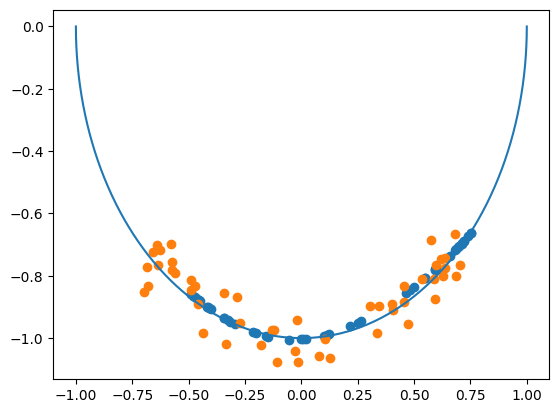

In [12]:
data_dict = {y_in:ydata[np.random.randint(0,Ndata,1),:,:],beta:1.0}
input_traj = sess.run(y_in,feed_dict=data_dict)
trajectory = sess.run(y_hat,feed_dict=data_dict)
plt.plot(np.cos(np.linspace(np.pi,2.*np.pi,100)),np.sin(np.linspace(np.pi,2.*np.pi,100)))
plt.scatter(trajectory[0][:,0],trajectory[0][:,1])
plt.scatter(input_traj[0][:,0],input_traj[0][:,1])